## Imports

In [1]:
import pathlib
import os
import os.path as osp
import sys
import argparse
parent_path = pathlib.Path(os.getcwd()).parent.absolute()
sys.path.append(str(parent_path))

import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import MovieLens

from utils.gnn_simple import Model
from utils.train_test import train_test
from utils.grid_search import grid_search
from utils.visualize import plot_loss, plot_train, plot_val, plot_test

/home/atha/diploma/environ/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read the dataset

In [3]:
path = osp.join(osp.dirname(osp.abspath('')), '../../data/MovieLens')
dataset = MovieLens(path, model_name='all-MiniLM-L6-v2')
data = dataset[0].to(device)

#### Preprocess the dataset

In [4]:
# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes

# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

# Perform a link-level split into training, validation, and test edges:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

#### Define and train-test the model for numerous GNN layer types

In [5]:
layer_names = ["SAGE", "GraphConv", "GAT"]

losses = grid_search(
    layer_names=layer_names,
    encoder_min_num_layers=5,
    encoder_max_num_layers=5,
    decoder_min_num_layers=5,
    decoder_max_num_layers=5,
    epochs=400,
    data=data,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    device=device,
    logging_step=10,
    encoder_skip_connections_=[True],
)

--->> ('SAGE', 5, True, 5)


/home/atha/diploma/environ/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 010, Loss: 12.7230, Train: 2.8269, Val: 2.8158, Test: 2.8216
Epoch: 020, Loss: 7.8976, Train: 1.1193, Val: 1.1142, Test: 1.1374
Epoch: 030, Loss: 6.0595, Train: 1.3862, Val: 1.3783, Test: 1.3943
Epoch: 040, Loss: 5.9276, Train: 1.4761, Val: 1.4649, Test: 1.4749
Epoch: 050, Loss: 5.7813, Train: 1.2074, Val: 1.2007, Test: 1.2125
Epoch: 060, Loss: 5.4562, Train: 1.2707, Val: 1.2595, Test: 1.2813
Epoch: 070, Loss: 5.0832, Train: 1.2625, Val: 1.2693, Test: 1.2735
Epoch: 080, Loss: 4.5275, Train: 1.1793, Val: 1.1809, Test: 1.1747
Epoch: 090, Loss: 3.9882, Train: 1.2021, Val: 1.1770, Test: 1.2189
Epoch: 100, Loss: 3.6755, Train: 1.1286, Val: 1.1605, Test: 1.1533
Epoch: 110, Loss: 3.5221, Train: 1.3403, Val: 1.3490, Test: 1.3558
Epoch: 120, Loss: 3.3124, Train: 1.1093, Val: 1.1123, Test: 1.1513
Epoch: 130, Loss: 3.2841, Train: 1.1201, Val: 1.1457, Test: 1.1754
Epoch: 140, Loss: 3.1321, Train: 1.1618, Val: 1.1948, Test: 1.2070
Epoch: 150, Loss: 3.1073, Train: 1.1248, Val: 1.1688, Test: 1

#### Visualize

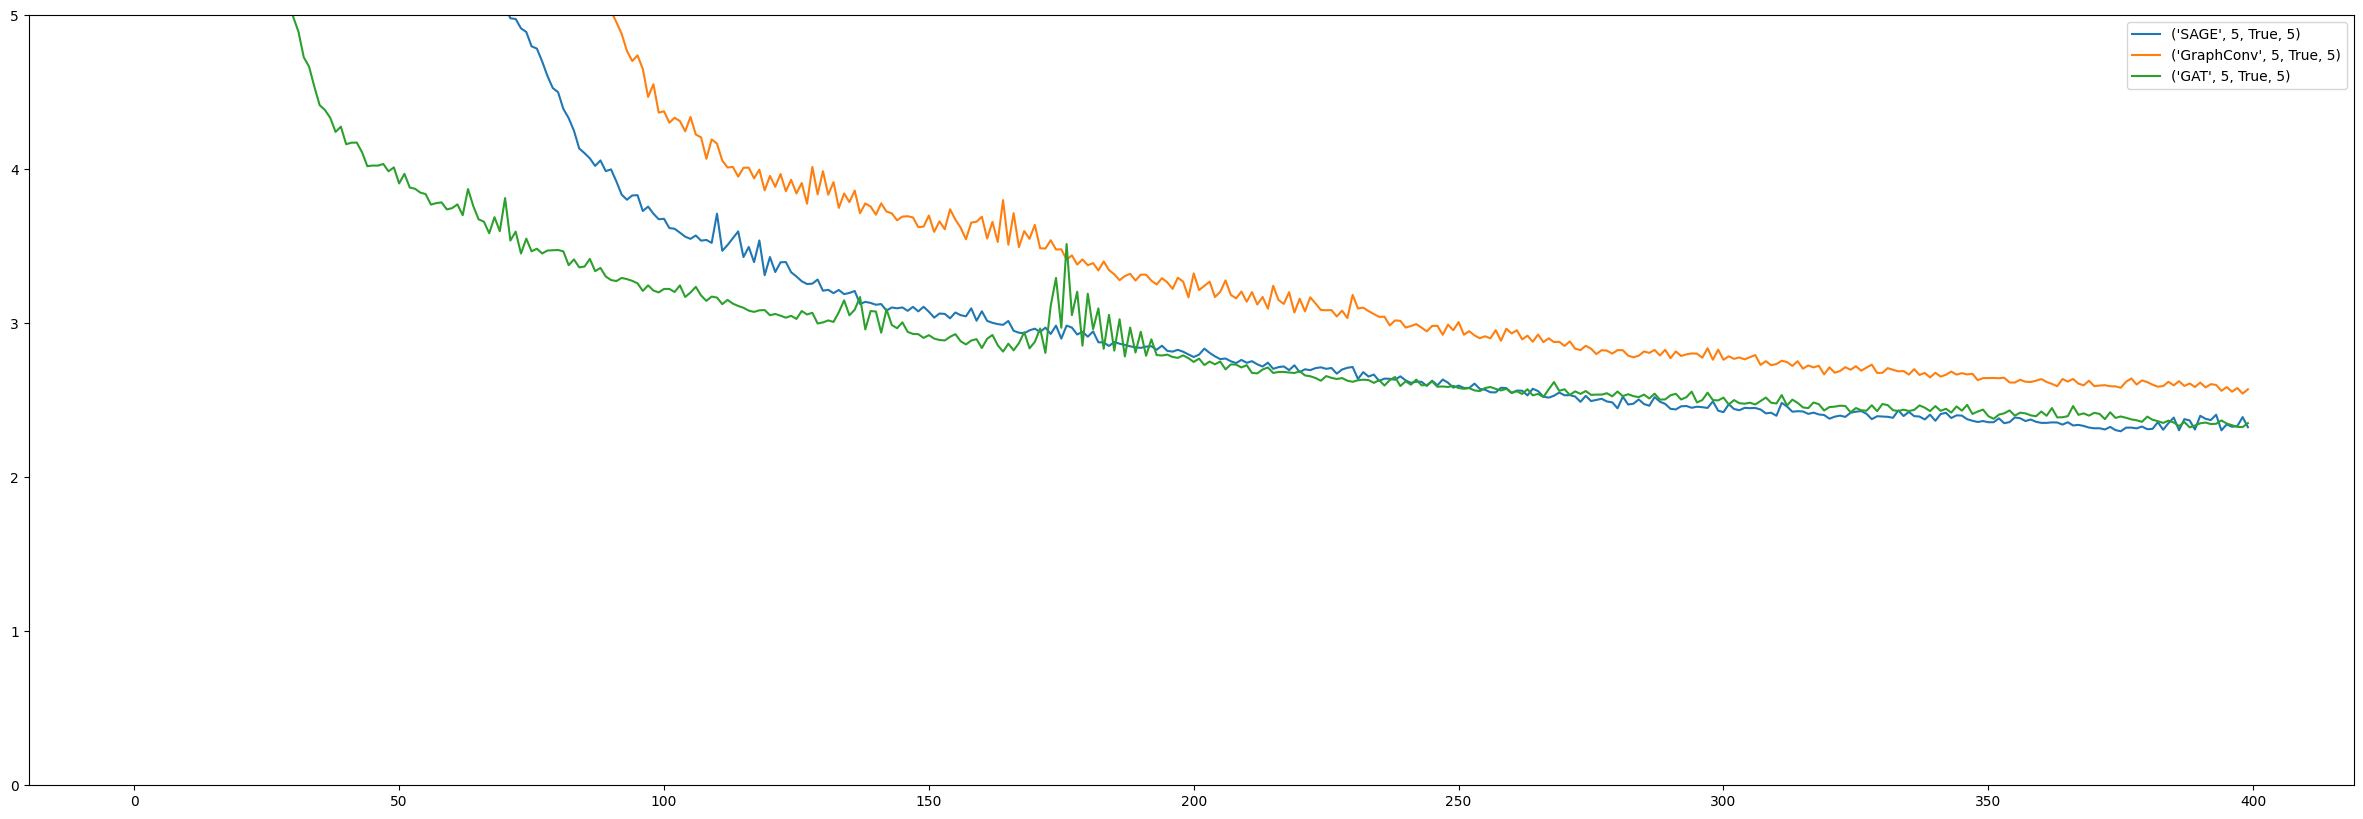

In [8]:
plot_loss(losses, ylim=5)